In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

# Binned Spectra

In [4]:
f0, f1 = '143', '143'
split0, split1 = '1', '2'
lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

In [5]:
def get_bonus_bins(width=5, l_max=30, l_min=2):
    """Generate a list of left and right bins for ell < 30 
    
    These are needed to properly account for mode coupling.
    """
    left = np.arange( (l_max - l_min) / width ).astype(int) * width 
    left = left[left + (width - 1) >= l_min]
    return np.maximum(l_min,left), left + (width - 1)

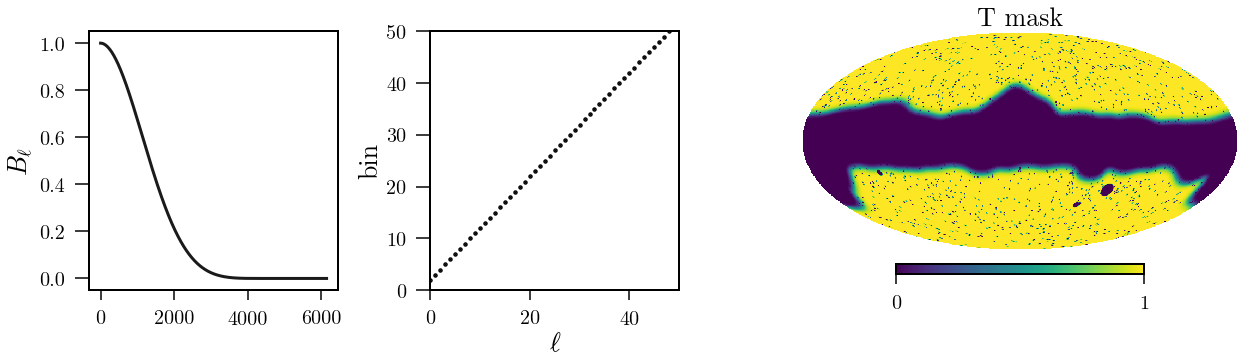

In [13]:
beam_filename = f'../planck_beam/beam_probably_used_in_2015_likelihood_{f0}hm1x{f1}hm2.dat.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

# binleft, binright = np.genfromtxt('../planck_spectra/binused.dat', 
#                                   unpack=True, usecols=(0,1), dtype=((int), (int)))
# bonus_left, bonus_right = get_bonus_bins(width=5, l_min=2)
# binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
    
# ells = np.arange(lmax+1)
# bpws = -1+np.zeros_like(ells) #Array of bandpower indices
# for i, (bl, br) in enumerate(zip(binleft, binright)):
#     bpws[bl:br+1] = i
# weights = np.array([1 / np.sum(bpws == bpws[l]) for l in ells])
# b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=True)

b = nmt.NmtBin(nside, nlb=1)
lb = b.get_effective_ells()

mask0t = hp.read_map(f'../masks/COM_Mask_Likelihood-temperature-{f0}_2048_R2.00.fits', verbose=False)
mask1t = hp.read_map(f'../masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)

fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(b.bin_cell(np.arange(lmax_beam)), 'k.')
ax[1].set_xlim(0,50)
ax[1].set_ylim(0,50)

ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

In [15]:
c0_file = f'../maps/PR2/frequencyMaps/HFI_SkyMap_{f0}_2048_R2.02_halfmission-{split0}.fits'
c1_file = f'../maps/PR2/frequencyMaps/HFI_SkyMap_{f1}_2048_R2.02_halfmission-{split1}.fits'
cov0 = hp.read_map(c0_file, field=4, verbose=False) # II_COV
cov1 = hp.read_map(c1_file, field=4, verbose=False) # II_COV

badpix0 = (cov0<-1e30)
badpix1 = (cov1<-1e30)

mask0t[badpix0] = 0.0
mask1t[badpix1] = 0.0

/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [16]:
def subtract_mono_di(map_in, mask_in):
    map_masked = hp.ma(map_in)
    map_masked.mask = (mask_in<1)
    mono, dipole = hp.pixelfunc.fit_dipole(map_masked)
    print(mono, dipole)
    m = map_in.copy()
    npix = hp.nside2npix(nside)
    bunchsize = npix // 24
    bad = hp.UNSEEN
    for ibunch in range(npix // bunchsize):
        ipix = np.arange(ibunch * bunchsize, (ibunch + 1) * bunchsize)
        ipix = ipix[(np.isfinite(m.flat[ipix]))]
        x, y, z = hp.pix2vec(nside, ipix, False)
        m.flat[ipix] -= dipole[0] * x
        m.flat[ipix] -= dipole[1] * y
        m.flat[ipix] -= dipole[2] * z
        m.flat[ipix] -= mono
        
    return m

def get_Nl(theta_fwhm=(10., 7., 5.),
             sigma_T=(68.1, 42.6, 65.4),
             f_sky=0.6, l_min=2, l_max=2500,
             verbose=False):
    """
    Get TT noise curve.
    Uses the Planck bluebook parameters by default.
    Parameters
    ----------
        theta_fwhm (list of float): beam resolution in arcmin
        sigma_T (list of float): temperature resolution in muK
        sigma_P (list of float): polarization resolution in muK
        f_sky (float): sky fraction covered
        l_min (int): minimum ell for CMB power spectrum
        l_max (int): maximum ell for CMB power spectrum
        verbose (boolean): flag for printing out debugging output
    """

    # convert from arcmin to radians
    theta_fwhm = theta_fwhm * np.array([np.pi/60./180.])
    sigma_T = sigma_T * np.array([np.pi/60./180.])
    num_channels = len(theta_fwhm)
    f_sky = f_sky
    ells = np.arange(l_max+1)

    # compute noise in muK**2, adapted from Monte Python
    noise_T = np.zeros(l_max+1, 'float64')
    for l in range(l_min, l_max+1):
        noise_T[l] = 0
        for channel in range(num_channels):
            noise_T[l] += sigma_T[channel]**-2 *\
                np.exp(
                    -l*(l+1)*theta_fwhm[channel]**2/8./np.log(2.))
        noise_T[l] = 1/noise_T[l]
    return noise_T

In [17]:
realization_l_max = 6144

In [18]:
import healpy as hp
import classy
cosmo = classy.Class()
cosmo.set({'output':'tCl,pCl,lCl', 'lensing':'yes', 
           'l_max_scalars':realization_l_max})
cosmo.compute()
cl = cosmo.lensed_cl()

true_TT = cl['tt'] * (cosmo.T_cmb() * 1e6)**2

In [19]:
beam_in_radians = 10 * np.pi/10800 # 10 arcmin
m = hp.synfast(true_TT, nside=2048, new=True, pixwin=True)
noise1 = hp.synfast(get_Nl(l_max=realization_l_max), nside=2048,new=True, pixwin=True)
noise2 = hp.synfast(get_Nl(l_max=realization_l_max), nside=2048,new=True, pixwin=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [20]:
noisy_m1 = hp.smoothing(m + noise1, fwhm=beam_in_radians)
noisy_m2 = hp.smoothing(m + noise2, fwhm=beam_in_radians)

Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [21]:
cl_out = hp.anafast(noisy_m1, noisy_m2)

In [22]:
pixwin = hp.sphtfunc.pixwin(nside)
beam = hp.gauss_beam(10 * np.pi/10800, lmax=lmax_beam)

(0.5, 50000.0)

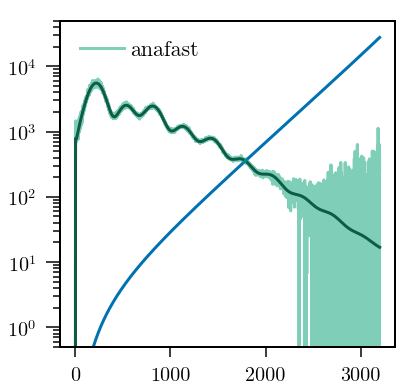

In [23]:
display_lmax = 3200

plt.figure(figsize=(6,6))

dl_fac = np.arange(display_lmax)**2 / 2 / np.pi
plt.plot( true_TT[:display_lmax] * dl_fac )
plt.plot( get_Nl(l_max=display_lmax-1) * dl_fac )

plt.plot(cl_out[:display_lmax] * dl_fac / 
         (pixwin[:display_lmax]**2 * beam[:display_lmax]**2), 
         alpha=0.5, label='anafast')

plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5,5e4)

In [24]:
def get_maps():
    beam_in_radians = 10 * np.pi/10800 # 10 arcmin
    m = hp.synfast(true_TT, nside=2048, new=True, pixwin=True)
    noise1 = hp.synfast(get_Nl(l_max=realization_l_max), nside=2048,new=True, pixwin=True)
    noise2 = hp.synfast(get_Nl(l_max=realization_l_max), nside=2048,new=True, pixwin=True)
    
    noisy_m1 = hp.smoothing(m + noise1, fwhm=beam_in_radians)
    noisy_m2 = hp.smoothing(m + noise2, fwhm=beam_in_radians)
    
    return noisy_m1, noisy_m2

In [25]:
m1, m2 = get_maps()
m1[badpix0] = 0.0
m2[badpix1] = 0.0

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [24]:
hp.write_map('window0.fits', mask0t, overwrite=True)
hp.write_map('window1.fits', mask1t, overwrite=True)

hp.write_map('map0.fits', m1, overwrite=True)
hp.write_map('map1.fits', m2, overwrite=True)

In [76]:
import ispice
ispice.ispice(mapin1='map0.fits', weightfile1='window0.fits',
              mapfile2='map1.fits', weightfile2='window1.fits',
              subdipole='NO', subav='NO', nlmax=realization_l_max,
              clout='cl.fits')

Submitting job 0
/home/zequnl/Installs/PolSpice_v03-05-01/bin/./spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -decouple NO -mapfile map0.fits -mapfile2 map1.fits -fits_out YES -weightfile window0.fits -weightfile2 window1.fits -nlmax 6144 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


0

In [28]:
from astropy.io import fits

rawcl = fits.open('cl.fits')[1].data['TT'] / beam[:realization_l_max]**2
binned_ell = np.array([ np.sum(ells[bpws==bp])/np.sum(bpws==bp)
                       for bp in range(len(binleft)) ])
Cb_polspice = np.array([ np.sum(
        rawcl[ells[bpws==bp]]) / np.sum(bpws==bp) 
                          for bp in range(len(binleft)) ])

In [26]:
i0 = nmt.NmtField(mask0t,[m1], beam=(beam[:-1]*pixwin), n_iter=3)
i1 = nmt.NmtField(mask1t,[m2], beam=(beam[:-1]*pixwin), n_iter=3)

cl_coupled=nmt.compute_coupled_cell(i0,i1)
w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(i0,i1,b)
dl_00=w0.decouple_cell(cl_coupled)[0]

array([4.46644986e+02, 4.02614773e+02, 1.71570177e+02, ...,
       1.73356204e+17, 1.81193649e+17, 7.90587503e+16])

(0.5, 50000.0)

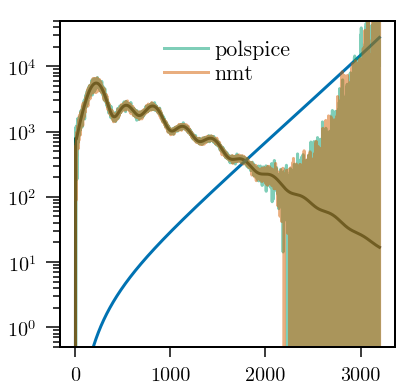

In [35]:
display_lmax = 3200

plt.figure(figsize=(6,6))

dl_fac = np.arange(display_lmax)**2 / 2 / np.pi
plt.plot( true_TT[:display_lmax] * dl_fac )
plt.plot( get_Nl(l_max=display_lmax-1) * dl_fac )

# plt.plot(cl_out[:display_lmax] * dl_fac / 
#          (pixwin[:display_lmax]**2 * beam[:display_lmax]**2), 
#          alpha=0.5, label='anafast')

plt.plot(np.arange(display_lmax), rawcl[:display_lmax]*dl_fac, alpha=0.5, label='polspice')
plt.plot(lb[:display_lmax], dl_00[:display_lmax] * dl_fac, alpha=0.5, label='nmt')

plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5,5e4)

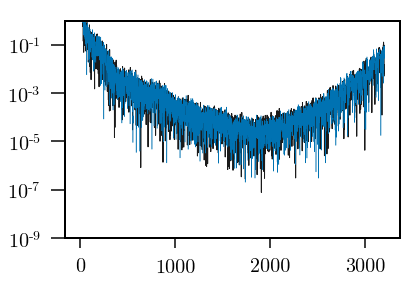

In [44]:
plt.plot( np.abs(rawcl[:display_lmax] - true_TT[:display_lmax]), lw=1 )
plt.plot( np.abs(dl_00[:display_lmax] - true_TT[:display_lmax]), lw=0.5 )
plt.ylim(1e-9, 1.0)
plt.yscale('log')

(0, 10)

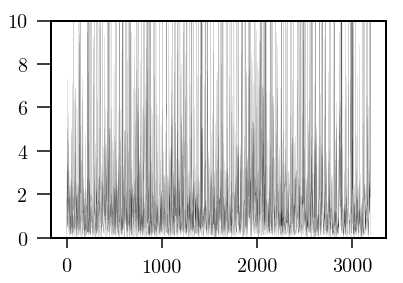

In [52]:
plt.plot( np.abs(rawcl[:display_lmax] - true_TT[:display_lmax]) / 
         np.abs(dl_00[:display_lmax] - true_TT[:display_lmax]), lw=0.1 )
# plt.plot( , lw=0.5 )
plt.ylim(0, 10)
# plt.yscale('log')

In [60]:
# n_sims = 20

# for i in range(n_sims):

SyntaxError: unexpected EOF while parsing (<ipython-input-60-80287467f662>, line 3)

In [27]:
fits.open('cl.fits')[1].data['TT'].shape

(3101,)